In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
df = pd.read_csv('20191226-reviews.csv',engine='python')
df = df.head(1000)
print(df.shape)

(1000, 8)


Quick EDA

In [ ]:
df.head()

,asin,name,rating,date,verified,title,body,helpfulVotes
0,B0000SX2UC,Janet,3,"October 11, 2005",False,"Def not best, but not worst",I had the Samsung A600 for awhile which is abs...,1.0
1,B0000SX2UC,Luke Wyatt,1,"January 7, 2004",False,Text Messaging Doesn't Work,Due to a software issue between Nokia and Spri...,17.0
2,B0000SX2UC,Brooke,5,"December 30, 2003",False,Love This Phone,"This is a great, reliable phone. I also purcha...",5.0
3,B0000SX2UC,amy m. teague,3,"March 18, 2004",False,"Love the Phone, BUT...!","I love the phone and all, because I really did...",1.0
4,B0000SX2UC,tristazbimmer,4,"August 28, 2005",False,"Great phone service and options, lousy case!",The phone has been great for every purpose it ...,1.0


In [ ]:
df['row_id']= [x+1 for x in range(len(df))]

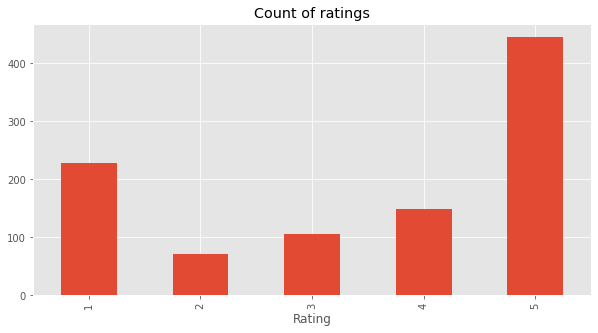

In [ ]:
ax = df['rating'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of ratings',
          figsize=(10, 5))
ax.set_xlabel('Rating')
plt.show()

In [ ]:
example = df['body'][50]
print(example)

This is not a "boost" phone and will not work as a GPS with Boost. Had to send it back. A huge pain for something that is $24. This is a rip-off.


In [ ]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['This', 'is', 'not', 'a', '``', 'boost', "''", 'phone', 'and', 'will']

In [ ]:
tagged = nltk.pos_tag(tokens)
tagged[:3]

[('This', 'DT'), ('is', 'VBZ'), ('not', 'RB')]

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [ ]:
sia.polarity_scores(example)

{'neg': 0.099, 'neu': 0.751, 'pos': 0.15, 'compound': 0.1779}

## Running Polarity scores on entire dataset

In [ ]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = str(row['body'])
    myid = row['row_id']
    res[myid] = sia.polarity_scores(text)


  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
# res

In [ ]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'row_id'})
vaders = vaders.merge(df, how='left')

In [ ]:
vaders.head()

,row_id,neg,neu,pos,compound,asin,name,rating,date,verified,title,body,helpfulVotes
0,1,0.080,0.816,0.105,0.8629,B0000SX2UC,Janet,3,"October 11, 2005",False,"Def not best, but not worst",I had the Samsung A600 for awhile which is abs...,1.0
1,2,0.020,0.876,0.104,0.8860,B0000SX2UC,Luke Wyatt,1,"January 7, 2004",False,Text Messaging Doesn't Work,Due to a software issue between Nokia and Spri...,17.0
2,3,0.051,0.846,0.103,0.7992,B0000SX2UC,Brooke,5,"December 30, 2003",False,Love This Phone,"This is a great, reliable phone. I also purcha...",5.0
3,4,0.000,0.844,0.156,0.9592,B0000SX2UC,amy m. teague,3,"March 18, 2004",False,"Love the Phone, BUT...!","I love the phone and all, because I really did...",1.0
4,5,0.066,0.814,0.121,0.7745,B0000SX2UC,tristazbimmer,4,"August 28, 2005",False,"Great phone service and options, lousy case!",The phone has been great for every purpose it ...,1.0


## Plotting Vader Results

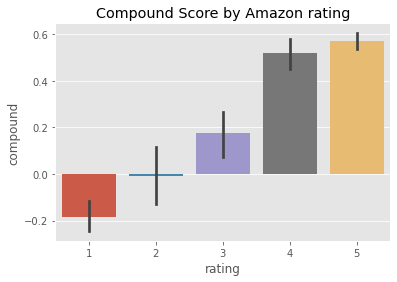

In [ ]:
ax = sns.barplot(data=vaders, x='rating', y='compound')
ax.set_title('Compound Score by Amazon rating')
plt.show()

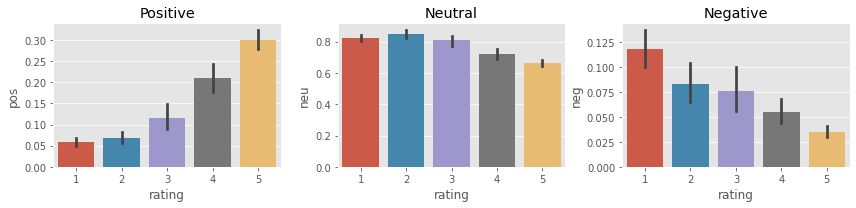

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='rating', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='rating', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='rating', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [ ]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

Downloading:   0%|          | 0.00/747 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
# VADER results on example
print(example)
sia.polarity_scores(example)

This is not a "boost" phone and will not work as a GPS with Boost. Had to send it back. A huge pain for something that is $24. This is a rip-off.


{'neg': 0.099, 'neu': 0.751, 'pos': 0.15, 'compound': 0.1779}

In [ ]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.9261213, 'roberta_neu': 0.06435086, 'roberta_pos': 0.009527853}


In [ ]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [ ]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['body']
        myid = row['row_id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/1000 [00:00<?, ?it/s]

Broke for id 20
Broke for id 41
Broke for id 83
Broke for id 85
Broke for id 101
Broke for id 146
Broke for id 621
Broke for id 667
Broke for id 668
Broke for id 829
Broke for id 868
Broke for id 985


In [28]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'row_id'})
results_df = results_df.merge(df, how='left')

In [29]:
results_df.head()

,row_id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,asin,name,rating,date,verified,title,body,helpfulVotes
0,1,0.080,0.816,0.105,0.8629,0.387844,0.342091,0.270065,B0000SX2UC,Janet,3,"October 11, 2005",False,"Def not best, but not worst",I had the Samsung A600 for awhile which is abs...,1.0
1,2,0.020,0.876,0.104,0.8860,0.459493,0.425768,0.114739,B0000SX2UC,Luke Wyatt,1,"January 7, 2004",False,Text Messaging Doesn't Work,Due to a software issue between Nokia and Spri...,17.0
2,3,0.051,0.846,0.103,0.7992,0.134225,0.299039,0.566736,B0000SX2UC,Brooke,5,"December 30, 2003",False,Love This Phone,"This is a great, reliable phone. I also purcha...",5.0
3,4,0.000,0.844,0.156,0.9592,0.009765,0.021803,0.968431,B0000SX2UC,amy m. teague,3,"March 18, 2004",False,"Love the Phone, BUT...!","I love the phone and all, because I really did...",1.0
4,5,0.066,0.814,0.121,0.7745,0.236581,0.328687,0.434733,B0000SX2UC,tristazbimmer,4,"August 28, 2005",False,"Great phone service and options, lousy case!",The phone has been great for every purpose it ...,1.0


## Reviewing some of the examples (Having a look at some examples where model scoring and customer ratings differ the most)

### For the result below, our roberta model gave a positive polarity while the customer rating was 1. Lets have a look at the review

In [30]:
results_df.query('rating == 1') \
    .sort_values('roberta_pos', ascending=False)['body'].values[0]

'Brand new - out of the box - I charged this phone as instructed (four hours - I gave it six) and when unplugged - black screen. I am returning to Amazon.'

##### Maybe in this case, as there are no negative words involved, the model confused this statement as positive

### For the result below, our Vader model gave a positive polarity while the customer rating was 1. Lets have a look at the review

In [31]:
results_df.query('rating == 1') \
    .sort_values('vader_pos', ascending=False)['body'].values[0]

"You're sounding like Ebay"

##### Maybe in this case, as there are no negative words involved, the model confused this statement as positive

### Now lets check some results with negative sentiments and 5 star ratings

### For the result below, our roberta model gave a negative polarity while the customer rating was 5. Lets have a look at the review

In [32]:
results_df.query('rating == 5') \
    .sort_values('roberta_neg', ascending=False)['body'].values[1]

"This phone has lasted me three years and it's only now starting to cause me problems. And that's probably because I don't treat it too well. I'm most likely going to buy the same phone to replace it."

##### In this case, the model might have picked up problems as a negative word however, when we read the review, we can understand that it is indeed a good review

### For the result below, our Vader model gave a negative polarity while the customer rating was 5. Lets have a look at the review

In [33]:
results_df.query('rating == 5') \
    .sort_values('vader_neg', ascending=False)['body'].values[1]

'Turns out Verizon no longer supports this phone shame'

##### In this case, it seems the customer has problem with Verizon and not the cell cell phone for which the review is written. So model does well in indentifying the sentence as negative sentiment but could not understand the context. Great example!